In [2]:
# Access astronomical databases
from pyvo import registry  # version >=1.4.1 

# Moc and HEALPix tools
from mocpy import MOC

# Sky visualization
from ipyaladin import Aladin

# For plots
import matplotlib.pyplot as plt

from astropy.table import Table

# Welcome to VizieR example workflow

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

It is a generic notebook, highlighting what can be done once you chose a catalog. This workflow is suggested by [CDS](https://cdsweb.unistra.fr/) (Strasbourg Astronomical Data Center, house of [VizieR](https://vizier.cds.unistra.fr/viz-bin/VizieR)).

--------------------------------------------------------

Modify the <a href='https://vizier.cds.unistra.fr/'>VizieR catalogue</a> name (variable <b>CATALOGUE</b>) and anything else you might feel like exploring!

## 1. Setup

This example notebook has the following dependencies: 

**Required**
- pyvo : this library facilitates the access to the Virtual Observatory (VO) resources. VizieR is part of the VO.
This notebook needs version >=1.4.1

**Optional, for visualization**
- ipyaladin : this is the Aladin-lite sky viewer, bundled as a jupyter widget. It allows to plot catalogs and multi-order coverages (MOC)
- matplotlib : an other option to see catalog points and MOCs

## 2. Metadata exploration with the Virtual Observatory registry

This part uses [pyvo](https://pyvo.readthedocs.io/en) to connect to the VO registry.

In [3]:
# the catalogue name in VizieR
CATALOGUE = "II/346"

We first retrieve catalogue information.

In [4]:
# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

In [4]:
# We can print metadata information about the catalogue
voresource.describe(verbose=True)

JMMC Stellar Diameters Catalogue - JSDC. Version 2
Short Name: II/346
IVOA Identifier: ivo://cds.vizier/ii/346
Access modes: conesearch, tap#aux, web
Multi-capability service -- use get_service()

This catalogue contains stellar angular diameter estimates for nearly all the
stars of the Hipparcos and Tycho catalogue that have an associated spectral
type in Simbad/CDS. The median error on the diameters is around 1.5%, with
possible biases of around ~2%. For each object, the limb-darkened diameter
retained is the mean value of several estimates performed using different
couples of photometries. The chi-square representing the dispersion between
these values is also given (it is below 2 for ~400000 stars). An additional
flag signals stars that could represent a risk if chosen as calibrators for
Optical Long-Baseline Interferometry, independently of the correctness of
their apparent diameter estimate. This catalog replaces the catalog
II/300/jsdc .

Waveband Coverage: infrared, optical

So

We can also inspect in details the `resource` object and access the attributes not provided by the describe method. See for example, the first author of a resource: 

In [5]:
voresource.creators[0]

'Bourges L.'

## 3. Access the tabular data of this catalog

We can have a look at the tables available in the catalogue.

In [6]:
tables = voresource.get_tables()
tables

{'II/346/jsdc_v2': <VODataServiceTable name="II/346/jsdc_v2">... 39 columns ...</VODataServiceTable>,
 'II/346/jsdc_dis': <VODataServiceTable name="II/346/jsdc_dis">... 11 columns ...</VODataServiceTable>}

In [7]:
# We can also extract the tables names for later use
tables_names = list(tables.keys())
tables_names

['II/346/jsdc_v2', 'II/346/jsdc_dis']

The actual data can then be access using any of the ``access_modes`` of the voresource.

In [8]:
voresource.access_modes()

{'conesearch', 'tap#aux', 'web'}

The web access is found by following the ``reference_url``

In [9]:
voresource.reference_url

'https://cdsarc.cds.unistra.fr/viz-bin/cat/II/346'

### 3.1 Execute a SQL/ADQL query

The ``tap#aux`` in the ``access_mode`` response indicates that we can also do a SQL/ADQL query for these VizieR tables.

On the first table of the catalogue, we execute an <a href='https://www.ivoa.net/documents/latest/ADQL.html'>ADQL</a> query.

In [8]:
# get the first table of the catalogue
table_name = 'II/346/jsdc_v2'

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(
    f'select recno, Name, RAJ2000, DEJ2000, LDD, e_LDD, Vmag, SpType from "{table_name}"',
)
tap_records

<DALResultsTable length=465877>
recno      Name        RAJ2000      ...  e_LDD     Vmag   SpType
                         deg        ...   mas      mag          
int32     object       float64      ... float64  float64  object
------ ----------- ---------------- ... -------- ------- -------
 40141   HD  18667     45.034152875 ... 0.006655    8.34  G6/8IV
 40246 BD-00   478 45.1528620833333 ...  0.00206  10.017      F8
 40203 BD-00   473      45.09491375 ... 0.000891    9.93      A0
 40521 BD-00   483 45.5013447083333 ... 0.002745     9.5      G0
 40515 BD+00   500 45.4908541666667 ... 0.005306  10.383      K4
 39792   HD  18496 44.6194970833333 ... 0.007115   9.083   K0III
 39984 BD+00   491      44.85630125 ... 0.002396   9.967      G0
 40121 BD+00   493      45.00825375 ... 0.004786    9.63      K0
 40277   HD  18738 45.1959279166667 ... 0.002663    8.84     F3V
   ...         ...              ... ...      ...     ...     ...
414403 BD-01  4085      314.8185375 ... 0.008752   9.734  

<!-- section position -->

We will explore the other access modes here.

### 3.2. Execute a cone search query

We use the Simple Cone Search (<a href='https://www.ivoa.net/documents/latest/ConeSearch.html'>SCS</a>) protocol of the virtual observatory (only available for tables with positions).

Adapt the radius and position of the center to your needs.

In [9]:
conesearch_radius = 1 / 60.0  # in degrees
conesearch_center = (46.16455078125, 1.8654265345025227)

In [10]:
conesearch_records = voresource.get_service("conesearch").search(
    pos=conesearch_center,
    sr=conesearch_radius,
)
conesearch_records

<DALResultsTable length=1>
 _RAJ2000   _DEJ2000     _r   recno  RAJ2000   ... Meth r_Diam rem   R  
   deg        deg                              ...                      
 float64    float64   float64 int32   str10    ... str2  str3  str5 str1
---------- ---------- ------- ----- ---------- ... ---- ------ ---- ----
 46.158750   1.863611 0.00608  1146 03 04 38.1 ...   6H     W1          

## 4. Get the catalogue coverage

VizieR also provides the coverage of each catalogue with Multiple Order Coverage (<a href='https://ivoa.net/documents/MOC/'>MOC</a>) at order 10 -- meaning with a 0.001 rad spacial resolution.

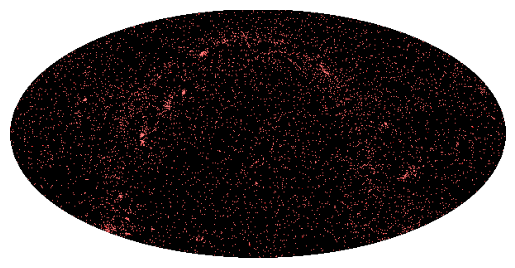

In [11]:
# retrieve the MOC
catalogue_coverage = MOC.from_fits(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
)
catalogue_coverage.display_preview()

We can plot the coverage with ``matplotlib``.

In [ ]:
fig = plt.figure(figsize=(5, 5))
wcs = catalogue_coverage.wcs(fig)
ax = fig.add_subplot(projection=wcs)
catalogue_coverage.fill(ax=ax, wcs=wcs, alpha=0.5, color="blue")

or with ipyaladin

In [12]:
aladin = Aladin()
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

We can add the tables and coverage in this ipyaladin window.

In [13]:
aladin.add_table(conesearch_records.to_table())

In [14]:
aladin.add_table(tap_records.to_table())

In [15]:
aladin.add_moc_from_URL(
    f"https://cdsarc.cds.unistra.fr/viz-bin/moc/{CATALOGUE}",
    moc_options={"opacity": 0.5, "color": "pink"},
)

For more information about manipulating coverages, see [MOCpy documentation](https://cds-astro.github.io/mocpy/).

In [14]:
# Remove any records with null RAJ2000 or DEJ2000 fields, and any records with a null ID1 field
tap_records_df = tap_records.to_table().to_pandas()
tap_records_df = tap_records_df.dropna(subset=["RAJ2000", "DEJ2000", "Name"])

# Filter out non main-sequence stars
tap_records_df = tap_records_df[tap_records_df["SpType"].str.contains("V")]

# Remove Sub-giants and sub-dwarfs
tap_records_df = tap_records_df[~tap_records_df["SpType"].str.contains("IV")]
tap_records_df = tap_records_df[~tap_records_df["SpType"].str.contains("VI")]

tap_records_df

,recno,Name,RAJ2000,DEJ2000,LDD,e_LDD,Vmag,SpType
8,40277,HD 18738,45.195928,0.993409,0.107498,0.002663,8.840,F3V
14,40809,HD 19002,45.871063,1.512188,0.119962,0.003286,9.030,F6V
16,39945,HD 18571,44.819833,1.244571,0.064205,0.001768,8.640,A0V
25,41166,HD 19188,46.329149,1.271046,0.190678,0.005273,9.128,G6/8V
26,41667,HD 19449,46.935802,1.847568,0.106298,0.002705,8.843,F3V
...,...,...,...,...,...,...,...,...
465858,413316,HD 199321,314.118162,-1.569394,0.104414,0.002380,9.399,F8/G0V
465860,413073,HD 199224,313.972451,-1.338416,0.074611,0.002057,9.628,F0V
465871,414450,HD 199788,314.853221,-0.539633,0.097247,0.002383,9.098,F3V
465873,414294,HD 199701,314.741604,-0.423181,0.089329,0.002322,9.100,A9/F0V


In [15]:
processed_vot_table = Table.from_pandas(tap_records_df)

In [16]:
# Save table as a VOTable file
processed_vot_table.write("data/stellar_ldd.vot", format="votable", overwrite=True)